In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.utils import compute_sample_weight
from sklearn.metrics import balanced_accuracy_score
from plot_learning_curve import plot_learning_curve, plot_validation_curve
import matplotlib.pyplot as plt
from sklearn import preprocessing

None


### Loading and Preprocessing Data

In [2]:
adult_train = pd.read_csv("adult-t.tsv", sep = "\t")
adult_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,42.0,4,308770.0,15,10.0,2,1,0,2,1,0.0,0.0,40.0,39,0
1,23.0,4,520231.0,15,10.0,4,10,1,4,0,0.0,0.0,45.0,39,1
2,27.0,4,164924.0,11,9.0,4,3,1,4,1,0.0,0.0,40.0,39,1
3,29.0,6,198286.0,9,13.0,4,10,1,4,0,0.0,0.0,40.0,39,1
4,32.0,4,197505.0,11,9.0,4,1,3,4,0,0.0,0.0,40.0,39,1


In [3]:
adult_train = pd.get_dummies(adult_train, columns=['workclass', 'education', 'sex', 'occupation', 'relationship', 'race', 'native-country', 'marital-status'])
adult_train.shape

(10000, 108)

In [4]:
normalize_columns = ['age', 'fnlwgt', 'capital-gain','capital-loss','hours-per-week']
def normalize(columns):
  scaler = preprocessing.StandardScaler()
  adult_train[columns] = scaler.fit_transform(adult_train[columns])
normalize(normalize_columns)

In [5]:
X = adult_train[[c for c in adult_train.columns if c != 'target']]
y = adult_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

### Trying Boosting Classifier without HyperParameter tunings

In [6]:
base_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

In [7]:
base_clf.fit(X_train, y_train)
y_train_pred = base_clf.predict(X_train)
y_test_pred = base_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  1.0
Test Accuracy:  0.7502033602508356


In [8]:
base_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

### Generate Learning Curve & Validation Curve with default classifier

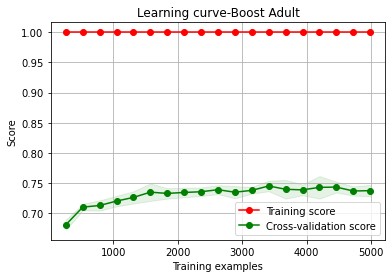

In [9]:
plot_learning_curve(base_clf, "Learning curve-Boost Adult", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

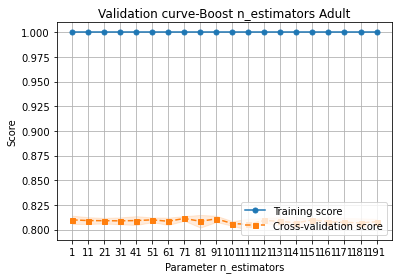

In [10]:
plot_validation_curve(base_clf, X_train, y_train, 'n_estimators', np.arange(1, 200, 10), cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-Boost n_estimators Adult")

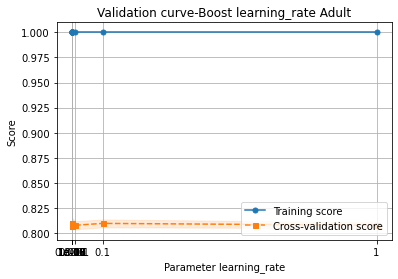

In [11]:
plot_validation_curve(base_clf, X_train, y_train, 'learning_rate', [0.0000000001, 0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-Boost learning_rate Adult")

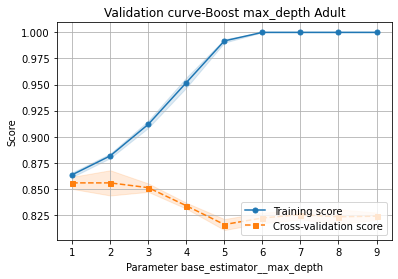

In [12]:
plot_validation_curve(base_clf, X_train, y_train, 'base_estimator__max_depth', np.arange(1, 10, 1), cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-Boost max_depth Adult")

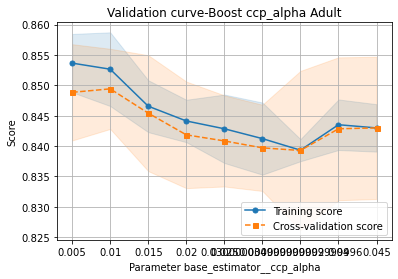

In [13]:
plot_validation_curve(base_clf, X_train, y_train, 'base_estimator__ccp_alpha', np.arange(0.005, 0.05, 0.005), cv=4, n_jobs=-1,scoring=make_scorer(balanced_accuracy_score), title="Validation curve-Boost ccp_alpha Adult")

### Conducting GridSearch to obtain best HyperParameters

In [14]:
param_grid = {
'learning_rate': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], #[0.25, 0.5, 0.75, 1.0],
'n_estimators': np.arange(10, 700, 50), #[50, 70, 90, 150],
'base_estimator__max_depth': range(1,3)
}

In [15]:
grid_search = GridSearchCV(base_clf, param_grid= param_grid, cv=4, scoring=make_scorer(balanced_accuracy_score), verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 168 candidates, totalling 672 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3

GridSearchCV(cv=4,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': range(1, 3),
                         'learning_rate': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660])},
             scoring=make_scorer(balanced_accuracy_score), verbose=10)

In [16]:
grid_search.best_params_

{'base_estimator__max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 510}

In [17]:
grid_search.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.1, n_estimators=510)

In [18]:
grid_search.best_score_

0.7922033138088747

### Generating Learning Curve with tuned Hyperparameters

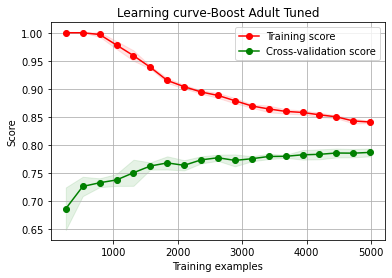

In [19]:
plot_learning_curve(grid_search.best_estimator_, "Learning curve-Boost Adult Tuned", X_train, y_train, ylim=None, cv=4, n_jobs=-1)

### Fitting classifier with best parameters and calculating test score

In [21]:
best_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.1, n_estimators=510)
best_clf.fit(X_train, y_train)
y_train_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)
print("Train Accuracy: ", balanced_accuracy_score(y_train, y_train_pred))
print("Test Accuracy: ", balanced_accuracy_score(y_test, y_test_pred))

Train Accuracy:  0.8277988640047631
Test Accuracy:  0.7809218505043334
